In [1]:
from __future__ import print_function
import time
import numpy as np
import theano
import theano.tensor as T
import lasagne
import cPickle as pickle
from cifar10_data import load_cifar10
# import lasagne_trainer

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, CuDNN 4007)
/home/saurabh/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [4]:
# set up plots

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

/Users/saurabh/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [3]:
# get data
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("../data/cifar-10-batches-py/")
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3, 32, 32)
Test labels shape:  (10000,)


In [4]:
X_val = X_test
y_val = y_test

In [14]:
input_var = T.tensor4('inputs')

In [15]:
def create_v1(input_var, input_shape=(3, 32, 32),
              ccp_num_filters=[64, 128], ccp_filter_size=3,
              fc_num_units=[128, 128], num_classes=10,
              **junk):
    # input layer
    network = lasagne.layers.InputLayer(shape=(None,) + input_shape,
                                        input_var=input_var)
    # conv-relu-conv-relu-pool layers
    for num_filters in ccp_num_filters:
        network = lasagne.layers.Conv2DLayer(
            network, num_filters=num_filters,
            filter_size=(ccp_filter_size, ccp_filter_size),
            pad='same',
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))
        network = lasagne.layers.Conv2DLayer(
            network, num_filters=num_filters,
            filter_size=(ccp_filter_size, ccp_filter_size),
            pad='same',
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))
        network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    # fc-relu
    for num_units in fc_num_units:
        network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=num_units,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))
    # output layer
    network = lasagne.layers.DenseLayer(
        lasagne.layers.dropout(network, p=.5),
        num_units=num_classes,
        nonlinearity=lasagne.nonlinearities.softmax)
    return network

In [16]:
param = dict(ccp_num_filters=[64, 128], 
             ccp_filter_size=3,
             fc_num_units=[256, 256],
             num_classes=10)

In [20]:
network = create_v1(input_var, **param)

In [21]:
def gen_minibatches(X, y, batch_size, shuffle=False):
    assert len(X) == len(y), "Training data sizes don't match"
    if shuffle:
        ids = np.random.permutation(len(X))
    else:
        ids = np.arange(len(X))
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        ii = ids[start_idx:start_idx + batch_size]
        yield X[ii], y[ii]

In [22]:
# Training params
learning_rate = 1
learning_rate_decay=1
decay_after_epochs=10

momentum=0.9
momentum_decay=0.5 

regu=0.0
batch_size=128 
num_epochs=25
save_path=None


print("Compiling...")

# Training Prediction
target_var = T.ivector('target')
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()
# regu_loss = lasagne.regularization.regularize_network_params(
#     network, lasagne.regularization.l2)
# loss = loss + regu * regu_loss
train_acc = T.mean(T.eq(T.argmax(prediction, axis=1), target_var),
                   dtype=theano.config.floatX)
learning_rate_var = theano.shared(np.float32(learning_rate))
# momentum_var = theano.shared(np.float32(momentum))
params = lasagne.layers.get_all_params(network, trainable=True)

updates = lasagne.updates.adagrad(
    loss, params, learning_rate=.01)

# Test prediction
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

train_fn = theano.function([input_var, target_var], loss, updates=updates)
train_acc_fn = theano.function([input_var, target_var], train_acc)
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

### All compilation done 

print("Training...")
best_val_acc = 0.0
best_model = None
loss_history = []
loss_test_history = []
train_acc_history = []
val_acc_history = []
for epoch in range(num_epochs):
    # train model for one pass
    train_err = train_batches = 0
    start_time = time.time()
    for X_batch, y_batch in gen_minibatches(X_train, y_train,
                                            batch_size, shuffle=True):
        err = train_fn(X_batch, y_batch)
        train_err += err
        train_batches += 1
        loss_history.append(err)
        
    # training accuracy
    n_acc = len(y_val)
    trval_err = trval_acc = trval_batches = 0
    for X_batch, y_batch in gen_minibatches(X_train[:n_acc], y_train[:n_acc],
                                            batch_size, shuffle=False):
        err, acc = val_fn(X_batch, y_batch)
        trval_err += err
        trval_acc += acc
        trval_batches += 1
    trval_acc /= trval_batches
    train_acc_history.append(trval_acc)
    
    # validation accuracy
    val_err = val_acc = val_batches = 0
    for X_batch, y_batch in gen_minibatches(X_val, y_val,
                                            batch_size, shuffle=False):
        err, acc = val_fn(X_batch, y_batch)
        val_err += err
        val_acc += acc
        val_batches += 1
        loss_test_history.append(err)
    val_acc /= val_batches
    val_acc_history.append(val_acc)
    
    
    print('epoch %d / %d in %.1fs: loss %f, train: %.3f, val %.3f, lr %e test_loss %e'
          % (epoch + 1, num_epochs, time.time() - start_time,
             train_err / train_batches, trval_acc, val_acc,
             learning_rate_var.get_value(), val_err/val_batches))
    
    # decay learning rate
    if (epoch + 1) % decay_after_epochs == 0:
        learning_rate_var.set_value(
            np.float32(learning_rate_var.get_value() * learning_rate_decay))
#         momentum = (1.0 - (1.0 - momentum_var.get_value()) * momentum_decay) \
#                    .clip(max=0.9999)
#         momentum_var.set_value(np.float32(momentum))


Compiling...
Training...
epoch 1 / 25 in 142.7s: loss 1.918315, train: 0.513, val 0.506, lr 1.000000e+00 test_loss 1.355012e+00
epoch 2 / 25 in 142.7s: loss 1.374881, train: 0.618, val 0.594, lr 1.000000e+00 test_loss 1.137217e+00
epoch 3 / 25 in 142.7s: loss 1.187211, train: 0.668, val 0.647, lr 1.000000e+00 test_loss 1.007537e+00
epoch 4 / 25 in 141.3s: loss 1.064630, train: 0.712, val 0.688, lr 1.000000e+00 test_loss 8.982949e-01
epoch 5 / 25 in 138.1s: loss 0.976648, train: 0.740, val 0.709, lr 1.000000e+00 test_loss 8.320429e-01
epoch 6 / 25 in 142.2s: loss 0.902045, train: 0.768, val 0.725, lr 1.000000e+00 test_loss 8.004160e-01
epoch 7 / 25 in 143.5s: loss 0.849720, train: 0.779, val 0.728, lr 1.000000e+00 test_loss 7.766256e-01
epoch 8 / 25 in 195.7s: loss 0.800804, train: 0.804, val 0.752, lr 1.000000e+00 test_loss 7.305999e-01
epoch 9 / 25 in 227.0s: loss 0.761225, train: 0.813, val 0.751, lr 1.000000e+00 test_loss 7.305280e-01
epoch 10 / 25 in 225.5s: loss 0.724262, train: 0

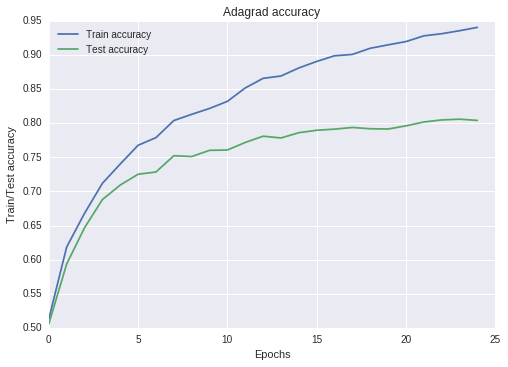

In [23]:
x = xrange(0,len(val_acc_history))
sigmoid_train = train_acc_history
sigmoid_test = val_acc_history
# sns.plt.ylim([91,100])
sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, sigmoid_train,  label = "Train accuracy" )
sns.plt.plot(x, sigmoid_test,  label = "Test accuracy" )
sns.plt.title("Adagrad accuracy")
sns.plt.legend(loc='upper left')

In [2]:
loss_test = [1.355012e+00,1.137217e+00,1.007537e+00,8.982949e-01,8.320429e-01,8.004160e-01,7.766256e-01,7.305999e-01,7.305280e-01,7.007490e-01,7.008702e-01,6.791198e-01,6.485035e-01,6.482311e-01,6.294840e-01,6.233590e-01,6.137135e-01,6.154913e-01,6.106227e-01,6.153910e-01,6.084288e-01,6.010406e-01,5.935571e-01,5.950802e-01,5.949434e-01]

loss_train = [1.918315,1.374881,1.187211,1.064630,0.976648,0.902045,0.849720,0.800804,0.761225,0.724262,0.691409,0.656783,0.635505,0.606395,0.579014,0.558652,0.535786,0.521200,0.502597,0.482212,0.469759,0.455398,0.437130,0.421473,0.413039]

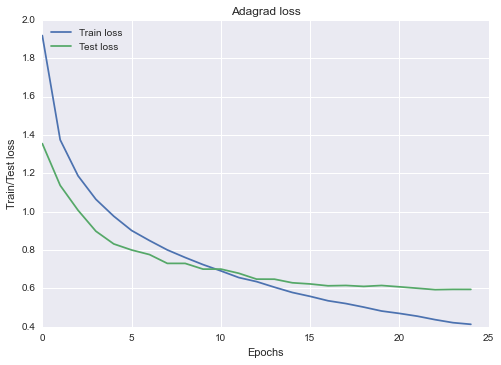

In [5]:
x = xrange(0,len(loss_train))
sigmoid_train = loss_train
sigmoid_test = loss_test
# sns.plt.ylim([91,100])
sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test loss")
sns.plt.plot(x, sigmoid_train,  label = "Train loss" )
sns.plt.plot(x, sigmoid_test,  label = "Test loss" )
sns.plt.title("Adagrad loss")
sns.plt.legend(loc='upper left')